In [166]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from sklearn.model_selection import  cross_validate, learning_curve, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor 

In [167]:
df = pd.read_csv('index.csv')
df.insert(0, "Date", pd.to_datetime(df[["Year", "Month", "Day"]]))      # create datetime column
df.set_index(["Date"], inplace=True)                                    # set index to date, easy to handle 
df.drop(columns=["Year", "Month", "Day"], inplace=True)                 # deop redundant columns
df.drop(columns=["Federal Funds Target Rate", "Federal Funds Upper Target", "Federal Funds Lower Target"], inplace=True)        # these columns will not be used


targ_df = pd.DataFrame(df["Real GDP (Percent Change)"])     # create target and drop the NaNs to get to quarterly values


# determine date when inflation rate begins to ve recorded 
for i,j in enumerate(df["Inflation Rate"]):
    if not np.isnan(j):
        print(f"Inflation rates begin: {df.index[i]}")
        break        
 
df.drop(df.loc["1954-07-01":"1958-01-01"].index, inplace=True)      # drop the rows with no inflation rate
df.drop(df.loc["2016-11-01":].index, inplace=True) # drop as there is no target for these dates
targ_df.drop(targ_df.loc["1954-07-01":"1958-01-01"].index, inplace=True)      # drop the rows with no inflation rate
targ_df.drop(targ_df.loc["2016-11-01":].index, inplace=True) # drop as there is no target for these dates



# remove mid-month entries as these were wgen target rates were chanmged, theses only contain NaNs for our feqture vaeriables 
idx_mm = [i for i,j in enumerate(df.index.day) if j != 1]
df.drop(df.iloc[idx_mm].index, inplace=True) 
# same for targ df
idx_mm = [i for i,j in enumerate(targ_df.index.day) if j != 1]
targ_df.drop(targ_df.iloc[idx_mm].index, inplace=True) 




tss = TimeSeriesSplit(n_splits = 2)         # use time series train test split so we do not train on future data, 2 splits to increse cv sample size
for train_index, test_index in tss.split(df, targ_df):
    X_train, X_test = df.iloc[train_index, :].copy(), df.iloc[test_index,:].copy()
    y_train, y_test = targ_df.iloc[train_index].copy(), targ_df.iloc[test_index].copy()
X_train.drop(columns="Real GDP (Percent Change)", inplace=True)
X_test.drop(columns="Real GDP (Percent Change)", inplace=True)



lags = [1,2,3,4,5]        # introduce lag features 
cols = ["Effective Federal Funds Rate", "Inflation Rate", "Unemployment Rate"]  
# loop and dynamically name lags for train
for col in cols:
    for L in lags:
        X_train[f"{col} lag{L}"] = X_train[col].shift(L)
# same for test
for col in cols:
    for L in lags:
        X_test[f"{col} lag{L}"] = X_test[col].shift(L)


X_train.drop(X_train.iloc[0:5].index, inplace=True)
X_test.drop(X_test.iloc[0:5].index, inplace=True)




# Now need to reduce to quartely evaluation: 
y_train = y_train.loc["1958-08-01":"1997-03-01"]        # limits of X_train
y_train = y_train.dropna()                              # get rid of monthly values
X_train = X_train.loc[y_train.index]                    # use index of targ to change X
print(f"Check indices: {sum(y_train.index != X_train.index)}")                     # check


# same for test dataset
y_test = y_test.loc["1997-10-01":"2016-10-01"]
y_test = y_test.dropna()
X_test = X_test.loc[y_test.index]
print(f"check indices: {sum(y_test.index != X_test.index)}")

# create quarterly lags for GDP
gdp_lags = [1,2,3]
for L in gdp_lags:
    X_train[f"Real GDP (Percent Change) lag{L}"] = y_train["Real GDP (Percent Change)"].shift(L)

for L in gdp_lags:
    X_test[f"Real GDP (Percent Change) lag{L}"] = y_test["Real GDP (Percent Change)"].shift(L)

X_train.drop(X_train.iloc[0:3].index, inplace=True)
X_test.drop(X_test.iloc[0:3].index, inplace=True)
y_train.drop(X_train.iloc[0:3].index, inplace=True)
y_test.drop(X_test.iloc[0:3].index, inplace=True)

print(f'NaNs in X_train: {X_train[["Unemployment Rate", "Effective Federal Funds Rate", "Inflation Rate"]].isna().sum()}')       # check if all are removed
print(f'NaNs in y_train: {y_train["Real GDP (Percent Change)"].isna().sum()}')        # check if all are removed
print(f'NaNs in X_test: {X_test[["Unemployment Rate", "Effective Federal Funds Rate", "Inflation Rate"]].isna().sum()}')        # check if all are removed
print(f'NaNs in y_test: {y_test["Real GDP (Percent Change)"].isna().sum()}')        # check if all are removed


X_train.head(6)

Inflation rates begin: 1958-01-01 00:00:00
Check indices: 0
check indices: 0
NaNs in X_train: Unemployment Rate               0
Effective Federal Funds Rate    0
Inflation Rate                  0
dtype: int64
NaNs in y_train: 0
NaNs in X_test: Unemployment Rate               0
Effective Federal Funds Rate    0
Inflation Rate                  0
dtype: int64
NaNs in y_test: 0


,Effective Federal Funds Rate,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate lag1,Effective Federal Funds Rate lag2,Effective Federal Funds Rate lag3,Effective Federal Funds Rate lag4,Effective Federal Funds Rate lag5,Inflation Rate lag1,Inflation Rate lag2,...,Inflation Rate lag4,Inflation Rate lag5,Unemployment Rate lag1,Unemployment Rate lag2,Unemployment Rate lag3,Unemployment Rate lag4,Unemployment Rate lag5,Real GDP (Percent Change) lag1,Real GDP (Percent Change) lag2,Real GDP (Percent Change) lag3
Date,,,,,,,,,,,,,,,,,,,,,
1959-07-01,3.47,5.1,2.0,3.39,2.90,2.96,2.80,2.43,2.0,2.0,...,1.7,1.7,5.0,5.1,5.2,5.6,5.9,10.1,7.7,9.7
1959-10-01,3.98,5.7,2.7,3.76,3.50,3.47,3.39,2.90,2.4,2.0,...,2.0,2.0,5.5,5.2,5.1,5.0,5.1,-0.8,10.1,7.7
1960-01-01,3.99,5.2,2.0,3.99,4.00,3.98,3.76,3.50,2.0,2.0,...,2.4,2.0,5.3,5.8,5.7,5.5,5.2,1.6,-0.8,10.1
1960-04-01,3.92,5.2,2.0,3.84,3.97,3.99,3.99,4.00,2.0,2.3,...,2.0,2.0,5.4,4.8,5.2,5.3,5.8,9.2,1.6,-0.8
1960-07-01,3.23,5.5,1.3,3.32,3.85,3.92,3.84,3.97,1.7,1.7,...,2.0,2.3,5.4,5.1,5.2,5.4,4.8,-1.5,9.2,1.6
1960-10-01,2.47,6.1,1.0,2.60,2.98,3.23,3.32,3.85,1.0,1.3,...,1.7,1.7,5.5,5.6,5.5,5.4,5.1,1.0,-1.5,9.2


In [168]:
X_train.columns

Index(['Effective Federal Funds Rate', 'Unemployment Rate', 'Inflation Rate',
       'Effective Federal Funds Rate lag1',
       'Effective Federal Funds Rate lag2',
       'Effective Federal Funds Rate lag3',
       'Effective Federal Funds Rate lag4',
       'Effective Federal Funds Rate lag5', 'Inflation Rate lag1',
       'Inflation Rate lag2', 'Inflation Rate lag3', 'Inflation Rate lag4',
       'Inflation Rate lag5', 'Unemployment Rate lag1',
       'Unemployment Rate lag2', 'Unemployment Rate lag3',
       'Unemployment Rate lag4', 'Unemployment Rate lag5',
       'Real GDP (Percent Change) lag1', 'Real GDP (Percent Change) lag2',
       'Real GDP (Percent Change) lag3'],
      dtype='object')

In [169]:
X_train2 = X_train.drop(columns=[c for c in X_train.columns if "GDP" in c])

In [170]:
abs(X_train.corrwith(y_train["Real GDP (Percent Change)"])).sort_values(ascending=False)

Effective Federal Funds Rate lag4    0.427075
Effective Federal Funds Rate lag5    0.417335
Effective Federal Funds Rate lag3    0.411639
Effective Federal Funds Rate lag2    0.374603
Effective Federal Funds Rate lag1    0.340545
Inflation Rate                       0.338071
Inflation Rate lag1                  0.335855
Inflation Rate lag2                  0.334910
Effective Federal Funds Rate         0.325568
Inflation Rate lag3                  0.318757
Inflation Rate lag4                  0.302891
Real GDP (Percent Change) lag1       0.287994
Inflation Rate lag5                  0.274062
Real GDP (Percent Change) lag2       0.216453
Unemployment Rate lag5               0.193678
Unemployment Rate lag4               0.167927
Unemployment Rate lag3               0.140050
Unemployment Rate lag2               0.108619
Unemployment Rate lag1               0.068909
Real GDP (Percent Change) lag3       0.053908
Unemployment Rate                    0.001200
dtype: float64

## Basic regression model as a test:

In [171]:
rand=48
reg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=0.1, random_state=rand))])         # instantiate pipeline class, setting the scaler and model (ridge regression)

# initialise a time-series aware cross validation method 
cv_reg = cross_validate(
    reg_pipe, X_train[[i for i in X_train.columns if "Effective" in i]], y_train, cv=tss, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True)


print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")

CV Mean R2 (train):  0.227 ± 0.028
CV Mean R2 (val):    -0.190  ± 0.190
CV Mean RMSE (val):  3.563
CV Mean MAE (val):   2.855


In [172]:
# initialise a time-series aware cross validation method 
cv_reg = cross_validate(
    reg_pipe, X_train2, y_train, cv=tss, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True)


print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")

CV Mean R2 (train):  0.515 ± 0.033
CV Mean R2 (val):    -0.225  ± 0.470
CV Mean RMSE (val):  3.368
CV Mean MAE (val):   2.696


## PCA

In [173]:
_ = StandardScaler().fit_transform(X_train)
pca = PCA(n_components=0.95, random_state=rand)     # PCs explain 95% of the variance 
X_pca = pca.fit_transform(_)
X_pca.shape
names = pca.get_feature_names_out()
X_pca_df = pd.DataFrame({names[0] : X_pca[:,0], 
                         names[1] : X_pca[:,1], 
                         names[2] : X_pca[:,2], 
                         names[3] : X_pca[:,3], 
                         names[4] : X_pca[:,4]})
X_pca_df.set_index(X_train.index, inplace=True)
X_pca_df.head(5)

,pca0,pca1,pca2,pca3,pca4
Date,,,,,
1959-07-01,-4.266252,0.457184,1.140030,1.490411,0.349469
1959-10-01,-3.583481,-0.121403,0.317490,-0.194183,1.556648
1960-01-01,-3.133817,0.088335,-0.237965,-0.875240,1.427111
1960-04-01,-3.278229,0.240577,-0.489622,0.017277,-1.916510
1960-07-01,-3.515672,-0.024830,-0.341755,-0.955839,0.299838


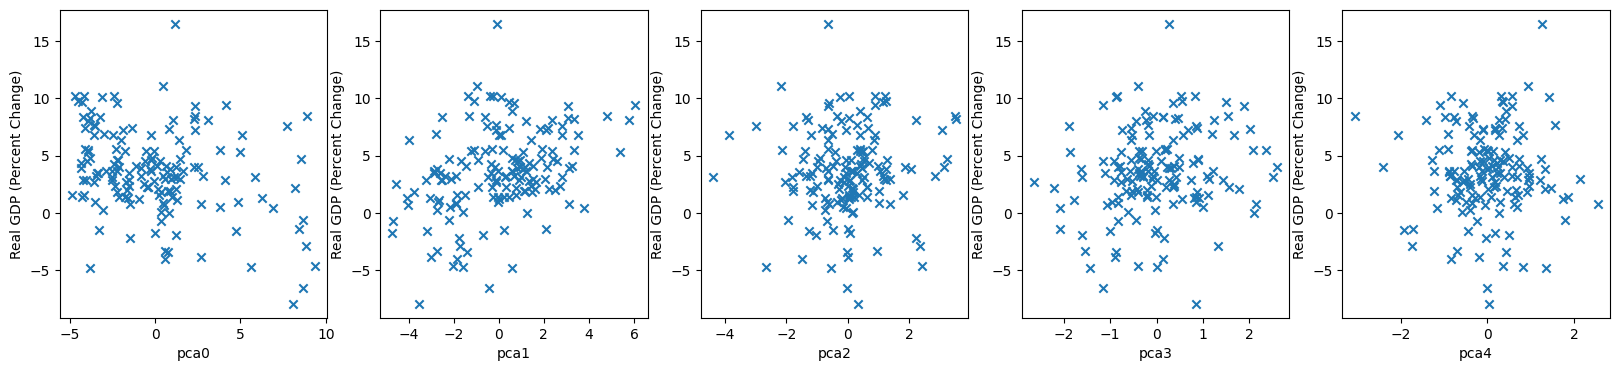

In [174]:
idx = X_pca_df.index
fig, ax = plt.subplots(1,5, figsize=(20,4))
for i,j in enumerate(X_pca_df.columns): 
    ax[i].scatter(X_pca_df[j], y_train["Real GDP (Percent Change)"], marker='x')
    ax[i].set_xlabel(f"{j}")
    ax[i].set_ylabel("Real GDP (Percent Change)")

In [175]:
X_pca_df.columns

Index(['pca0', 'pca1', 'pca2', 'pca3', 'pca4'], dtype='object')

In [176]:
print(f"Correlations with target: \n{X_pca_df.corrwith(y_train['Real GDP (Percent Change)'])}\n")
# for i in X_train.columns:
#     print(f"AVG correlation with {i}: \n{X_pca_df.corrwith(X_train[i]).sum()/5}")

Correlations with target: 
pca0   -0.297208
pca1    0.363667
pca2    0.028845
pca3    0.185849
pca4   -0.043536
dtype: float64



Now implement in the pipeline and test with linear regression:

In [177]:
pipe = Pipeline([("scaler", StandardScaler()), 
         ("PCA", PCA(n_components=0.95, random_state=rand)), 
         ("model", Ridge(alpha=0.1,random_state=rand))])

cv_reg = cross_validate(
    pipe, X_train, y_train, cv=tss, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True)


print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")

CV Mean R2 (train):  0.253 ± 0.059
CV Mean R2 (val):    -0.096  ± 0.371
CV Mean RMSE (val):  3.238
CV Mean MAE (val):   2.516


Note: way less overfitting

In [178]:
pipe = Pipeline([ 
         ("PCA", PCA(n_components=0.95, random_state=rand)), 
         ("model", RandomForestRegressor(n_estimators=100, random_state=rand))])

cv_reg = cross_validate(
    pipe, X_train, y_train["Real GDP (Percent Change)"], cv=tss, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True)


print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")

CV Mean R2 (train):  0.846 ± 0.025
CV Mean R2 (val):    -0.497  ± 0.711
CV Mean RMSE (val):  3.588
CV Mean MAE (val):   2.940


In [179]:
pipe = Pipeline([ 
         ("model", RandomForestRegressor(n_estimators=100, random_state=rand))])

cv_reg = cross_validate(
    pipe, X_train, y_train["Real GDP (Percent Change)"], cv=tss, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True)


print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")

CV Mean R2 (train):  0.860 ± 0.020
CV Mean R2 (val):    -0.631  ± 0.720
CV Mean RMSE (val):  3.800
CV Mean MAE (val):   3.092


In [180]:
pipe = Pipeline([
         ("PCA", PCA(n_components=0.95, random_state=rand)), 
         ("model", GradientBoostingRegressor(n_estimators=100, random_state=rand))])

cv_reg = cross_validate(
    pipe, X_train, y_train["Real GDP (Percent Change)"], cv=tss, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True)


print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")

CV Mean R2 (train):  0.980 ± 0.012
CV Mean R2 (val):    -0.629  ± 0.740
CV Mean RMSE (val):  3.778
CV Mean MAE (val):   3.166


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 400, 800],       # no of trees
    'max_depth': [None, 5, 10, 20, 40],         # limit tree depth 
    'min_samples_split': [2, 5, 10],            # min samples to split a node
    'min_samples_leaf': [1, 2, 4],              # min samples in leaf
    'max_features': ['sqrt', 'log2', 0.8, 0.5]} # features to consider when splitting       

rf = RandomForestRegressor(random_state=rand)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=30,                # number of random combinations to try
    cv=tss,                     # cross-validation folds
    scoring='r2',             # or 'neg_mean_squared_error'
    n_jobs=-1,
    verbose=2,
    random_state=42)

random_search.fit(X_train, y_train)

In [182]:
results = random_search.cv_results_
cv = pd.DataFrame(random_search.cv_results_)
cv_top = pd.DataFrame(cv.sort_values('mean_test_score', ascending=False).head(5))    # show the best 5
cv_top[['mean_test_score','std_test_score']]

,mean_test_score,std_test_score
22,-0.357957,0.477405
19,-0.362622,0.482071
4,-0.367621,0.494748
27,-0.372553,0.498376
7,-0.373900,0.481721


In [183]:
model = DecisionTreeRegressor(random_state=rand, max_depth=20)
cv_reg = cross_validate(
    pipe, X_train, y_train["Real GDP (Percent Change)"], cv=tss, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True)


print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")

CV Mean R2 (train):  0.980 ± 0.012
CV Mean R2 (val):    -0.629  ± 0.740
CV Mean RMSE (val):  3.778
CV Mean MAE (val):   3.166


In [185]:
model = DecisionTreeRegressor(random_state=rand, max_depth=20)

cv_reg = cross_validate(
    model, X_pca_df, y_train["Real GDP (Percent Change)"], cv=tss, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True)


print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")

CV Mean R2 (train):  1.000 ± 0.000
CV Mean R2 (val):    -3.733  ± 3.339
CV Mean RMSE (val):  5.613
CV Mean MAE (val):   4.426
